In [178]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
import seaborn as sns
from string import ascii_lowercase
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.quantum_info import Statevector
from qiskit.visualization import array_to_latex, plot_distribution, plot_histogram
from qiskit_algorithms import AmplificationProblem, Grover
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
from utils import get_image_path
from dotenv import load_dotenv
from qiskit_ibm_runtime import QiskitRuntimeService, Options, Sampler as IBMSampler, Session

In [126]:
def random_file_name(size=5):
    return ''.join(random.sample(list(ascii_lowercase), size))

In [128]:
def create_test_folder(folder):
    if(os.path.exists(folder)):
        print("Path already exists")
        print(f"Removing {folder}")
        shutil.rmtree(folder, ignore_errors=True)
    
    print(f"Creating: {folder}")
    os.mkdir(folder)
        
def create_test_files(folder, n=5):
    create_test_folder(folder)
    for _ in range(n):
        file = random_file_name()+".txt"
        
        try:
            print(f"creating file: {file}")
            file_path = os.path.join(folder, file)

            file = open(file_path, "a")
            file.close()
        
        except Exception as error:
            print(f"Failed creating {file}")


test_folder = os.path.join('.', 'files-test')
create_test_files(test_folder)

Path already exists
Removing ./files-test
Creating: ./files-test
creating file: blkzp.txt
creating file: mdhrg.txt
creating file: fyxjl.txt
creating file: gbcev.txt
creating file: egnvy.txt


In [129]:
files = os.listdir(test_folder)
files

['blkzp.txt', 'mdhrg.txt', 'fyxjl.txt', 'gbcev.txt', 'egnvy.txt']

In [130]:
def classical_method_1(files, target):
    #in this example, we are ignoring the extension
    #just for this case, in real life a good idea is to use the entire name, or a hash of it

    #unsing no type of lookup table, or sorting, the algorithm takes O(n)
    total_tests = 0
    for file in files:
        total_tests += 1
        print(f"total tests: {total_tests}")
        if(file.replace('.txt', '') == target):
            print("found file")
            break

classical_method_1(files, "fyxjl")

total tests: 1
total tests: 2
total tests: 3
found file


In [131]:
def classical_method_2(files, target):

    # this should be done after adding a file into the filesystem
    # it takes O(1) for adding a new file, O(n) for adding n files and O(1) for searching
    lut = {}
    for file in files:
        file_hash = hash(file.replace('.txt', ''))
        lut[file_hash] = file

    target_hash = hash(target)
    if lut.get(target_hash):
        print("File found")
    else:
        print("File doesnt exists in the filesystem")
        
classical_method_2(files, 'fyxjl')

File found


---

In [132]:
n_qubits = int(np.ceil(np.log2(len(files))))

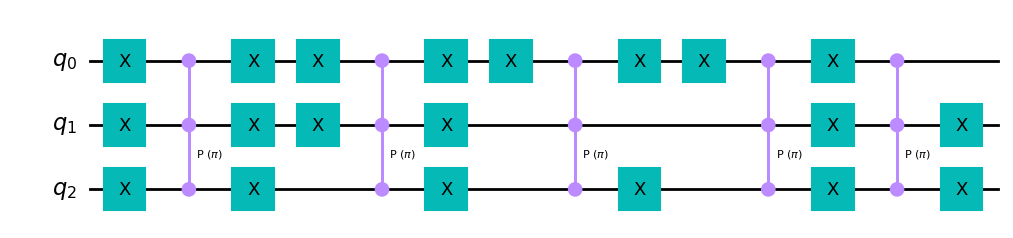

In [133]:
def encoding_files_to_oracle(n_qubits, files):
    oracle = QuantumCircuit(n_qubits, name="LUT")

    encoded_bin = [bin(i)[2:].zfill(n_qubits) for i in range(len(files))]

    for encoded in encoded_bin:
        x_positions = [i for i,char in enumerate(encoded) if char == '0']
        oracle.x(x_positions)
        oracle.mcp(np.pi, list(range(1,n_qubits)), 0)
        oracle.x(x_positions)

    return encoded_bin,oracle

binary,oracle = encoding_files_to_oracle(n_qubits,files)
oracle.draw('mpl', filename=get_image_path("look-up-table.png"))

In [134]:
def get_oracle_overload(files, targets):
    oracle = QuantumCircuit(n_qubits, name="$LUT^{-1}$")

    encode = lambda x,n: bin(x)[2:].zfill(n)
    encoded_bin = [encode(i,n_qubits) for i, file in enumerate(files) if file not in targets]

    for encoded in encoded_bin:
        x_positions = [i for i,char in enumerate(encoded) if char == '0']
        oracle.x(x_positions)
        oracle.mcp(np.pi, list(range(1,n_qubits)), 0)
        oracle.x(x_positions)

    return encoded_bin,oracle

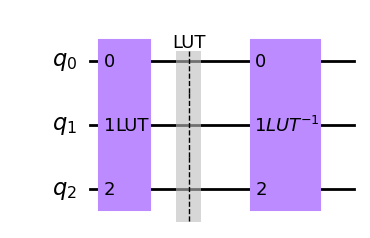

In [135]:
lut_binary,oracle = encoding_files_to_oracle(n_qubits,files)
unvalid_states,oracle_inv = get_oracle_overload(files, ['fyxjl.txt'])

good_state = list(set(lut_binary) - set(unvalid_states))

n_qubits = len(oracle.qubits)

qc = QuantumCircuit(n_qubits)
qc.append(oracle, range(n_qubits))
qc.barrier(label="LUT")
qc.append(oracle_inv, range(n_qubits))
qc.draw('mpl', filename=get_image_path("sets-difference-look-up-table-oracle.png"))

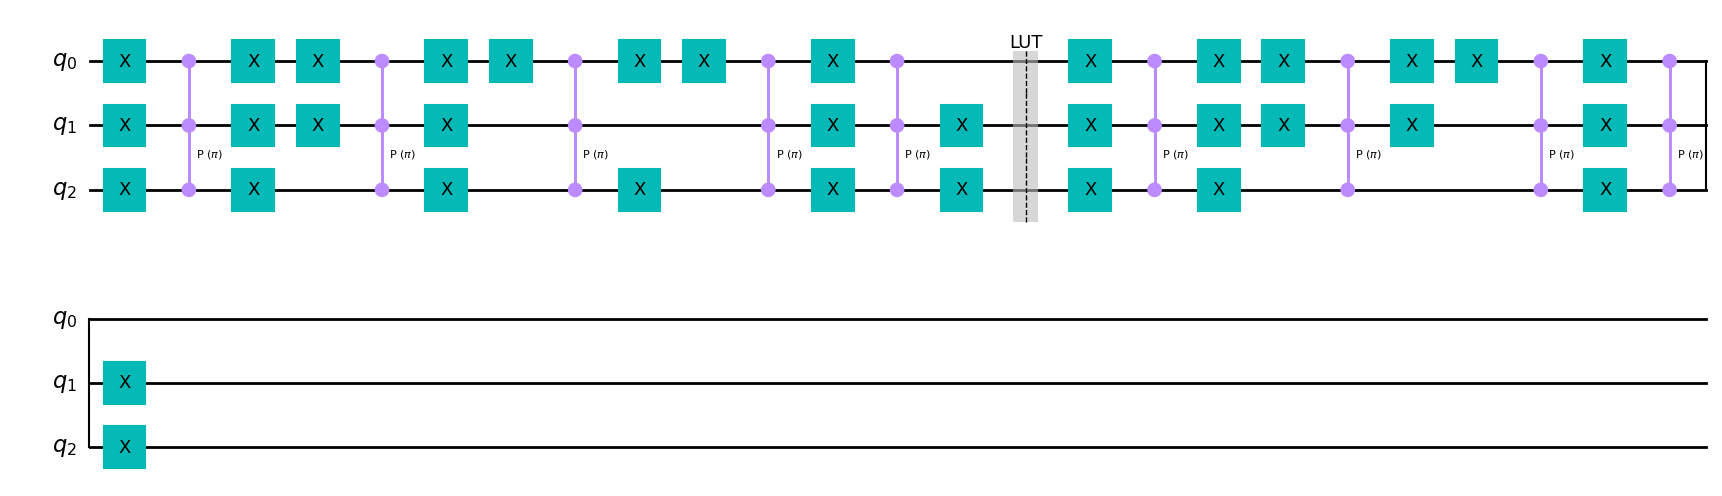

In [136]:
qc.decompose().draw('mpl')

In [137]:
Statevector(qc).draw('latex')

<IPython.core.display.Latex object>

In [138]:
qc_copy = qc.copy()
qc_copy.save_unitary()

sim = AerSimulator()
unitary = sim.run(transpile(qc_copy, sim)).result().get_unitary()
array_to_latex(unitary, max_size=10000)

<IPython.core.display.Latex object>

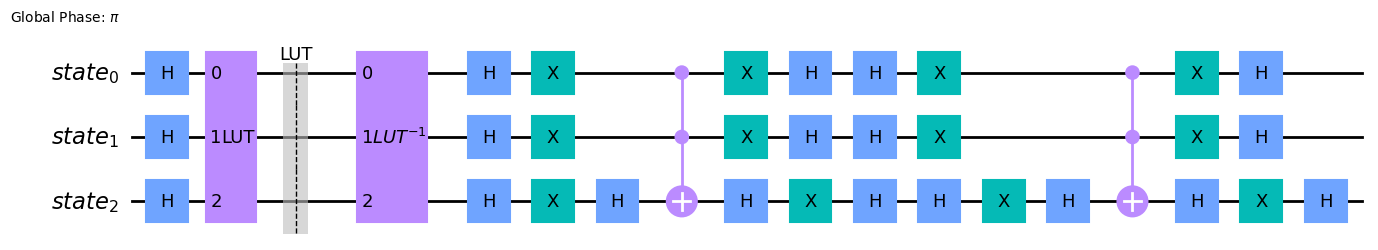

In [190]:
problem = AmplificationProblem(qc, is_good_state=good_state)
problem.grover_operator.decompose().draw(output='mpl')

In [140]:
grover = Grover(sampler=Sampler())
result = grover.amplify(problem)
result.top_measurement

'010'

---

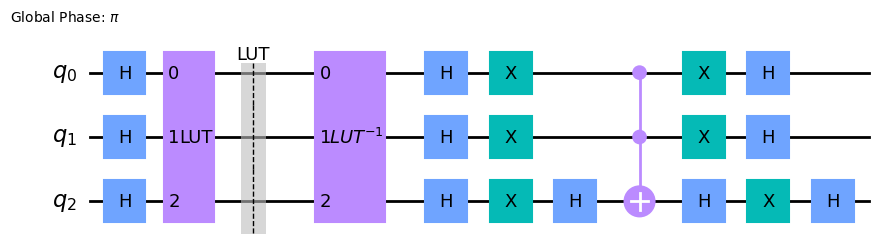

In [186]:
qc = QuantumCircuit(3)
qc.h(range(3))
qc.compose(problem.grover_operator.decompose(), range(3), inplace=True)
qc.draw('mpl')

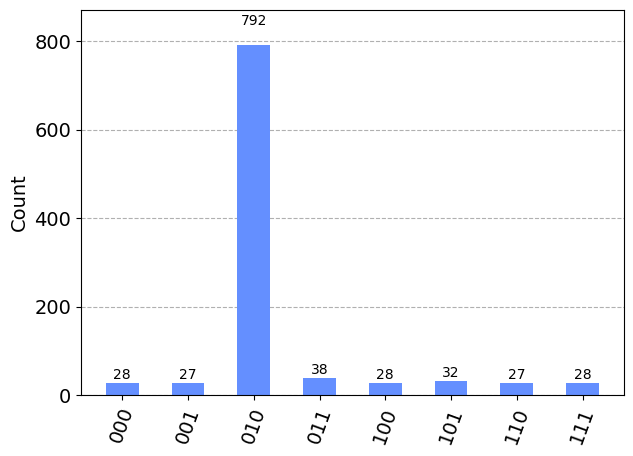

<Figure size 640x480 with 0 Axes>

In [189]:
sim = AerSimulator()
qc_copy = qc.copy()
qc_copy.measure_all()
aer_result = sim.run(transpile(qc_copy, sim), shots=1000).result().get_counts()
hist = plot_histogram(aer_result)
plt.savefig(get_image_path("AER-file-explorer-hist.png"))
display(hist)

---

In [85]:
load_dotenv()
QiskitRuntimeService.save_account(channel="ibm_quantum", token=os.getenv("IBM_TOKEN"), overwrite=True)

In [86]:
service = QiskitRuntimeService()
options = Options()
options.execution.shots = 1000

In [191]:
backend = service.least_busy(min_num_qubits=qc.num_qubits, operational=True, simulator=False)
display(backend.status())
print(f'num_qubits: {backend.num_qubits}') 

num_qubits: 127


In [192]:
def run_ibm(backend, qc, options):
    with Session(service=service, backend=backend):
        sampler = IBMSampler(backend=backend, options=options)
        qc_copy = qc.copy()
        qc_copy.measure_all()
        job = sampler.run(qc_copy)
        return job.result()

In [193]:
result = run_ibm(backend, qc, options)

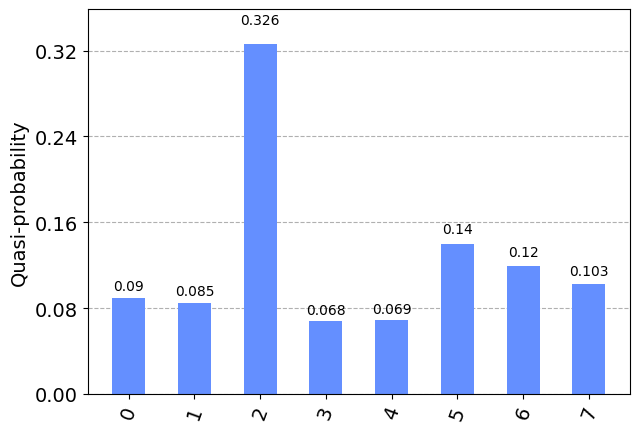

<Figure size 640x480 with 0 Axes>

In [194]:
dist = plot_distribution(result.quasi_dists)
plt.savefig(get_image_path("IBMQ-file-explorer-errors.png"))
display(dist)

In [195]:
options2 = Options(optimization_level=3)
options2.execution.shots = 1000

In [196]:
result2 = run_ibm(backend, qc, options2)

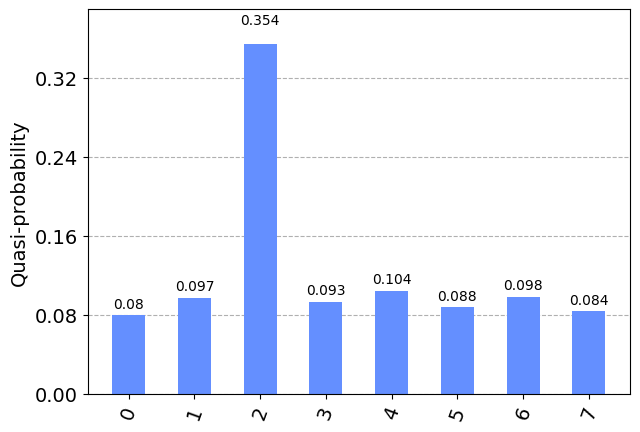

<Figure size 640x480 with 0 Axes>

In [198]:
dist2 = plot_distribution(result2.quasi_dists)
plt.savefig(get_image_path("IBMQ-file-explorer-error-correction.png"))
display(dist2)

---

In [199]:
x = np.array(list(range(0, 60)), dtype=np.int64)

classical_find = lambda x: x
classical_lut = lambda x: 1
quantum = lambda x: np.sqrt(x)

vec_cf = np.vectorize(classical_find)
vec_cl = np.vectorize(classical_lut)
vec_q = np.vectorize(quantum)

y_classical_f = vec_cf(x)
y_classical_l = vec_cl(x)
y_quantum = vec_q(x)

In [200]:
df = pd.DataFrame({"x":x, "cf":y_classical_f, "cl":y_classical_l, "q":y_quantum})
df.head()

,x,cf,cl,q
0,0,0,1,0.000000
1,1,1,1,1.000000
2,2,2,1,1.414214
3,3,3,1,1.732051
4,4,4,1,2.000000


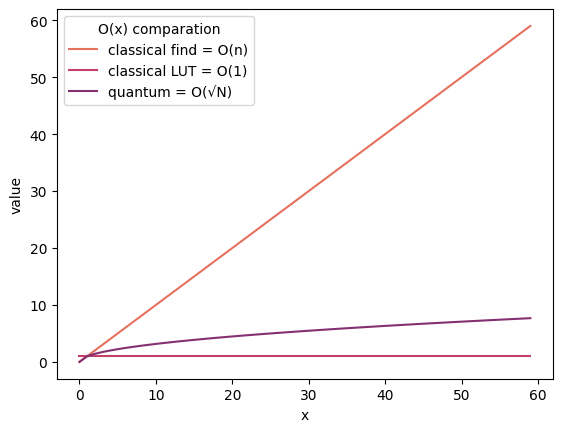

In [201]:
plot = sns.lineplot(data=pd.melt(df, ["x"]), x="x", y="value", hue="variable", palette="flare")

legend = plot.axes.get_legend()
legend.set_title("O(x) comparation")
for old, new in zip(legend.texts, ["classical find = O(n)", "classical LUT = O(1)", "quantum = O(√N)"]):
    old.set_text(new)

    
plt.savefig(get_image_path("algorithms-finding-comparation.png"))
plt.show(plot)